# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
import tensorflow as tf

# Pre-Processing

In [ ]:
def create_windows(df, window_size, prediction_range,stride, normalize_first, normalization):
  if normalize_first:
    normalized_data = normalize_data(df, normalization)
    X, Y = windows_from_normalized_data(normalized_data, window_size, prediction_range, stride)
    return X, Y
  else:
    X, Y = create_windows_and_predictions(df, normalization, window_size, stride)
    return X,Y

In [ ]:
def normalize_data(df, normalization):

    norm = normalization()
    normalized_data = norm.fit_transform(df.iloc[:, [1]])  # Apply normalization to I3_A
    df['Normalized_I3_A'] = normalized_data  # Normalized values
    return df
def windows_from_normalized_data(df, window_size, prediction_range, stride=1):
    X, Y = [], []

    # Create windows and corresponding future values
    for i in range(0, len(df) - window_size - prediction_range + 1, stride):
        window = df.iloc[i : i + window_size]
        future_values = df.iloc[i + window_size : i + window_size + prediction_range, -1]

        X.append(window.iloc[:, [-1]])
        Y.append(future_values)

    return np.array(X), np.array(Y)

In [ ]:
# normalize each window
def create_windows_and_predictions(df, normalization, window_size, prediction_range, stride):
    X, Y = [], []
    norm = normalization()

    # Loop through the data to create windows and corresponding future values
    for i in range(0, len(df) - window_size - prediction_range + 1, stride):
        window = df.iloc[i : i + window_size]
        future_values = df.iloc[i + window_size : i + window_size + prediction_range]

        # Normalizing the window and future values
        normalized_window = norm.fit_transform(window.iloc[:, [1]])
        normalized_future_values = norm.fit_transform(future_values.iloc[:, [1]])

        X.append(normalized_window)
        Y.append(normalized_future_values)

    # return windows,   preds
    return np.array(X), np.array(Y)


In [ ]:
from sklearn.model_selection import train_test_split

# Function to create train and test sets
def train_test_set(data, window_size, prediction_range, stride=1):
    X, Y = windows_from_normalized_data(data, window_size, prediction_range, stride)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
def load_dataset(path):
  data = pd.read_csv(path)

  my_data = data[['SensorDateTime', 'I3_A']]
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
  my_data['SensorDateTime_numeric'] = my_data['SensorDateTime'].map(pd.Timestamp.timestamp)  # تبدیل به عدد
  my_data = my_data[['SensorDateTime_numeric','I3_A']]

  return my_data

In [ ]:
def prepare_data(window_size, prediction_range,stride, normalize_first, normalization, path):
  # load data
  my_data = load_dataset(path)

  # windows and predictions
  X, Y = create_windows(my_data, window_size, prediction_range,stride, normalize_first, normalization)

  # train test set
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test


# Predicting Model

## Function

In [ ]:
def train_model(model, X_train, Y_train, X_test, Y_test, epochs, batch_size):

  model.compile(optimizer='adam', loss='mse')

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',   # scale
      # min_delta=5,      # minimum change to continue training
      patience=15,          # stop if it did not change after 30 epochs
      verbose=1,            # display info with some details
      mode='min',          # scale should decrease or increase
      restore_best_weights=True, # restore the best weights
  )

  model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,Y_test), callbacks=[early_stopping_callback])

  return model

## Models

In [ ]:
def GRU_model(window_size, prediction_range):
  input = tf.keras.layers.Input(shape=(window_size, 1))
  x = tf.keras.layers.GRU(128, return_sequences=True)(input)
  x = tf.keras.layers.GRU(256, return_sequences=True)(x)
  x = tf.keras.layers.Lambda(lambda t: t[:, -prediction_range:, :])(x)

  output = tf.keras.layers.Dense(1, activation='leaky_relu')(x)

  return input, output

input, output = GRU_model(window_size=24, prediction_range=12)
model = tf.keras.Model(input, output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 24, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 24, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 12, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12, 1)               │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,009 (1.32 MB)

 Trainable params: 347,009 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def Bi_GRU_model(window_size, prediction_range):
  input = tf.keras.layers.Input(shape=(window_size, 1))

  x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(input)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True))(x)

  x = tf.keras.layers.Lambda(lambda t: t[:, -prediction_range:, :])(x)

  output = tf.keras.layers.Dense(1, activation='leaky_relu')(x)

  return input, output

input, output = Bi_GRU_model(window_size=24, prediction_range=12)
model = tf.keras.Model(input, output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 24, 256)             │         100,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 24, 512)             │         789,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 12, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12, 1)               │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,625 (3.40 MB)

 Trainable params: 890,625 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

# Train

## Load Dataset and Prepare it

In [ ]:
X_train, X_test, Y_train, Y_test = prepare_data(window_size=128,
                                                prediction_range=30,
                                                stride=10,
                                                normalize_first=True,
                                                normalization=StandardScaler,
                                                path='/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/WashingMachine_PhaseCount_3_geq_2017-10-23_lt_2017-10-30.csv')

<ipython-input-8-4dadd16a454c>:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-8-4dadd16a454c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-8-4dadd16a454c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (8827, 128, 1)
Y_train shape: (8827, 30)
X_test shape: (2207, 128, 1)
Y_test shape: (2207, 30)


## Train models

### GRU

In [ ]:
"""
  window-size = 128
  stride = 10
  pred-range = 30
  epochs = 100

  model = 2 gru cell with 64 and 128 units and a dense layer with activation of leaky-relu

  loss = 0.1207
"""
input,output = GRU_model(window_size=128, prediction_range=30)
model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=32)

Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3492 - val_loss: 0.1830
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1895 - val_loss: 0.1786
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1813 - val_loss: 0.1788
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1856 - val_loss: 0.1776
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1845 - val_loss: 0.1760
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1860 - val_loss: 0.1752
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1811 - val_loss: 0.1796
Epoch 8/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1825 - val_loss: 0.1753
Epoch 9/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1812 - val_loss: 0.1757
Epoch 10/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1841 - val_loss: 0.1754
Epoch 11/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1799 - val_loss: 0.1751
Epoch 12/100
276/276 ━━━━━━━━━

In [ ]:
"""
  window-size = 128
  stride = 10
  pred-range = 30
  epochs=300

  model = 2 gru cell with 64 and 128 units and a dense layer with activation of leaky-relu

  loss =0.0867
"""
# input,output = GRU_model(window_size=128, prediction_range=30)
# model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=300, batch_size=32)

Epoch 1/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0506 - val_loss: 0.0935
Epoch 2/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0510 - val_loss: 0.0950
Epoch 3/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0525 - val_loss: 0.0938
Epoch 4/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0525 - val_loss: 0.0943
Epoch 5/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0535 - val_loss: 0.0965
Epoch 6/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0511 - val_loss: 0.0931
Epoch 7/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0506 - val_loss: 0.0914
Epoch 8/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0486 - val_loss: 0.0927
Epoch 9/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0499 - val_loss: 0.0921
Epoch 10/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0498 - val_loss: 0.0936
Epoch 11/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0513 - val_loss: 0.0948
Epoch 12/300
276/276 ━━━━━━━━━

In [ ]:
"""
  window-size = 128
  stride = 10
  pred-range = 30
  epochs = 300

  model = 2 gru cell with 128 and 256 units and a dense layer with activation of leaky-relu

  loss = 0.0474
"""
input,output = GRU_model(window_size=128, prediction_range=30)
model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=300, batch_size=32)

Epoch 1/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2783 - val_loss: 0.1814
Epoch 2/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1854 - val_loss: 0.1834
Epoch 3/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1856 - val_loss: 0.1804
Epoch 4/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1857 - val_loss: 0.1751
Epoch 5/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1820 - val_loss: 0.1754
Epoch 6/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.1797 - val_loss: 0.1812
Epoch 7/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1822 - val_loss: 0.1741
Epoch 8/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1809 - val_loss: 0.1739
Epoch 9/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1797 - val_loss: 0.1748
Epoch 10/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1797 - val_loss: 0.1774
Epoch 11/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1802 - val_loss: 0.1742
Epoch 12/300
276/276 ━━━━━━━━━

In [ ]:
"""
  window-size = 128
  stride = 1
  pred-range = 30
  epochs = 300

  model = 2 gru cell with 128 and 256 units and a dense layer with activation of leaky-relu

  loss = 0.0191
"""
input,output = GRU_model(window_size=128, prediction_range=30)
model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=300, batch_size=32)

Epoch 1/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.2033 - val_loss: 0.1826
Epoch 2/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 0.1803 - val_loss: 0.1732
Epoch 3/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.1744 - val_loss: 0.1610
Epoch 4/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 0.1557 - val_loss: 0.1380
Epoch 5/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.1365 - val_loss: 0.1166
Epoch 6/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.1112 - val_loss: 0.0913
Epoch 7/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 0.0850 - val_loss: 0.0733
Epoch 8/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.0684 - val_loss: 0.0585
Epoch 9/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 0.0567 - val_loss: 0.0538
Epoch 10/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0493 - val_loss: 0.0422
Epoch 11/300
2759/2759 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.0414 - val_loss: 0.03

###Bi-GRU



In [ ]:
"""
  window-size = 128
  stride = 10
  pred-range = 30
  epochs = 300

  model = 1 bi-gru cell with 64 units and a dense layer with activation of leaky-relu

  loss = 0.1557
"""
input,output = Bi_GRU_model(window_size=128, prediction_range=30)
model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=300, batch_size=32)

Epoch 1/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.4193 - val_loss: 0.1841
Epoch 2/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1893 - val_loss: 0.1806
Epoch 3/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1775 - val_loss: 0.1674
Epoch 4/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1707 - val_loss: 0.1650
Epoch 5/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1691 - val_loss: 0.1666
Epoch 6/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1680 - val_loss: 0.1661
Epoch 7/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1709 - val_loss: 0.1635
Epoch 8/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1695 - val_loss: 0.1647
Epoch 9/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1714 - val_loss: 0.1654
Epoch 10/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1674 - val_loss: 0.1647
Epoch 11/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1689 - val_loss: 0.1631
Epoch 12/300
276/276 ━━━━━━━━━

In [ ]:
"""
  window-size = 128
  stride = 10
  pred-range = 30
  epochs = 300

  model = 2 bi-gru cells with 64,128 units and a dense layer with activation of leaky-relu

  loss = 0.1573
"""
input,output = Bi_GRU_model(window_size=128, prediction_range=30)
model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=300, batch_size=32)

Epoch 1/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.3035 - val_loss: 0.1763
Epoch 2/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.1747 - val_loss: 0.1766
Epoch 3/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1697 - val_loss: 0.1616
Epoch 4/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.1662 - val_loss: 0.1624
Epoch 5/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.1667 - val_loss: 0.1683
Epoch 6/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1660 - val_loss: 0.1606
Epoch 7/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.1668 - val_loss: 0.1597
Epoch 8/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.1668 - val_loss: 0.1587
Epoch 9/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1683 - val_loss: 0.1604
Epoch 10/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.1668 - val_loss: 0.1606
Epoch 11/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.1645 - val_loss: 0.1585
Epoch 12/300
276/276 ━━━━

In [ ]:
"""
  window-size = 128
  stride = 10
  pred-range = 30
  epochs = 300

  model = 2 bi-gru cells with 128,256 units and a dense layer with activation of leaky-relu

  loss = 0.0800
"""
input,output = Bi_GRU_model(window_size=128, prediction_range=30)
model = tf.keras.Model(input, output)
model = train_model(model, X_train, Y_train, X_test, Y_test, epochs=300, batch_size=32)

Epoch 1/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.2854 - val_loss: 0.1669
Epoch 2/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.1740 - val_loss: 0.1688
Epoch 3/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.1674 - val_loss: 0.1614
Epoch 4/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1667 - val_loss: 0.1614
Epoch 5/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.1679 - val_loss: 0.1625
Epoch 6/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.1687 - val_loss: 0.1598
Epoch 7/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1661 - val_loss: 0.1605
Epoch 8/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.1664 - val_loss: 0.1598
Epoch 9/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.1667 - val_loss: 0.1595
Epoch 10/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.1636 - val_loss: 0.1614
Epoch 11/300
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.1642 - val_loss: 0.1610
Epoch 12/300
276/276 ━━━

# Visualize Predictions

## Functions

In [ ]:
def plot_comparison(y_test, predictions, epochs, window_size, prediction_range):

    predictions = predictions.reshape(predictions.shape[0], -1)
    zoom_samples = 100

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(y_test[:zoom_samples], color='blue', linewidth=2)
    plt.plot(predictions[:zoom_samples], color='red', linestyle='--', linewidth=2)
    plt.title(f"Epochs: {epochs}, Window: {window_size}, Pred Range: {prediction_range}")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_predictions(y_test, predictions):
  plt.figure(figsize=(25,10))
  for i in range(30):
    plt.subplot(6,5,i+1)
    plt.plot(y_test[i], color='blue')
    plt.plot(predictions[i], color='red')

## Visualize

### 2 GRU

#### 64,128 units    100 epochs    w=128   s=10    p=30

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


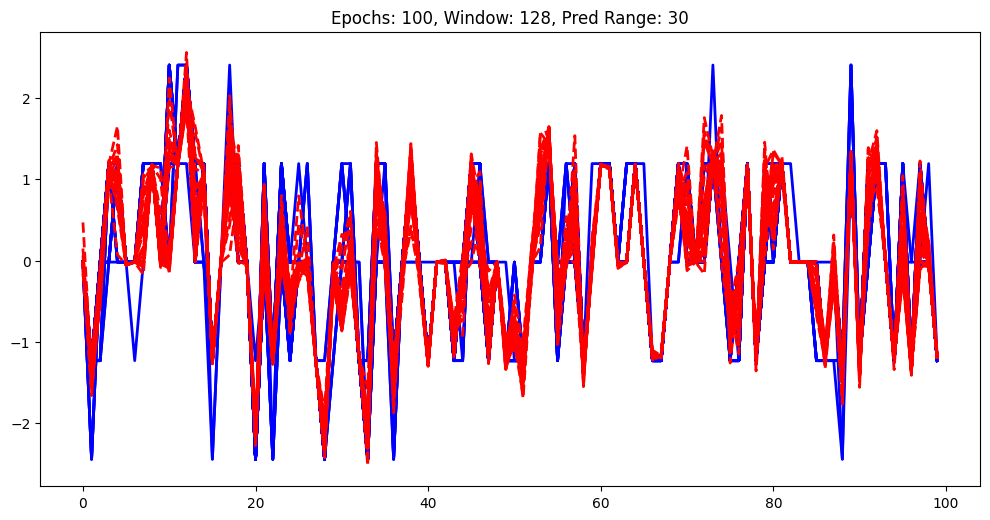

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=100, window_size=128, prediction_range=30)

#### 64,128 units    300 epochs  w=128   s=10    p=30

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


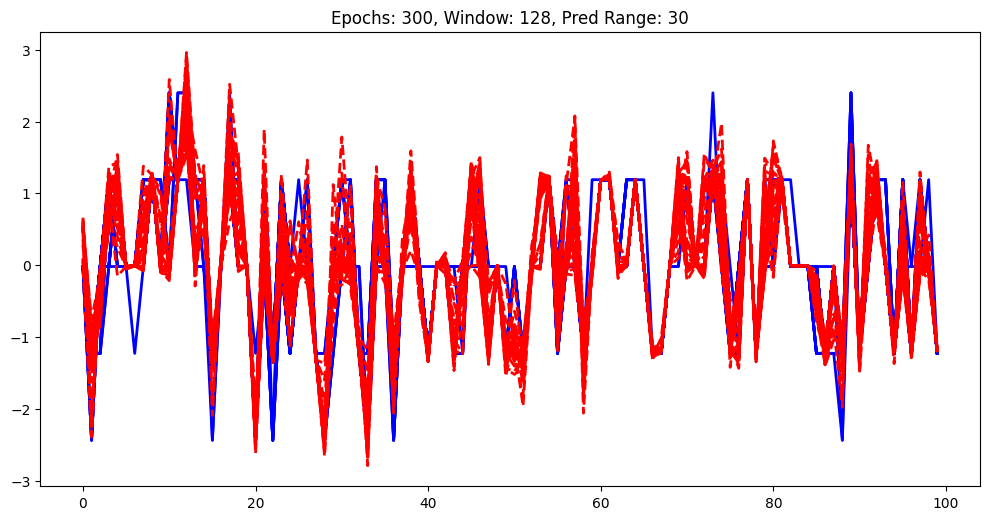

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=300, window_size=128, prediction_range=30)

#### 128,256 units    300 epochs w=128   s=10    p=30

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


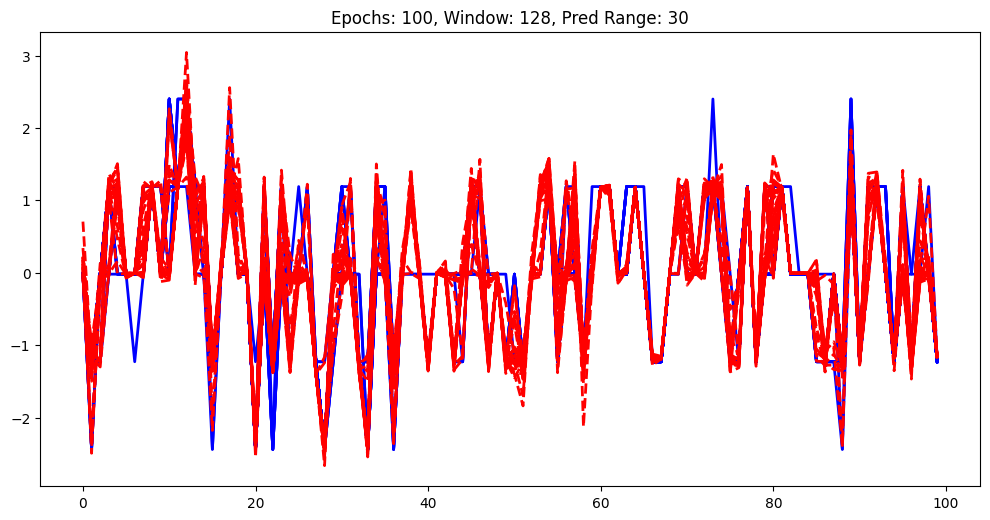

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=100, window_size=128, prediction_range=30)

#### 128,256 units   300 epochs   w=128   s=1   p=30

690/690 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


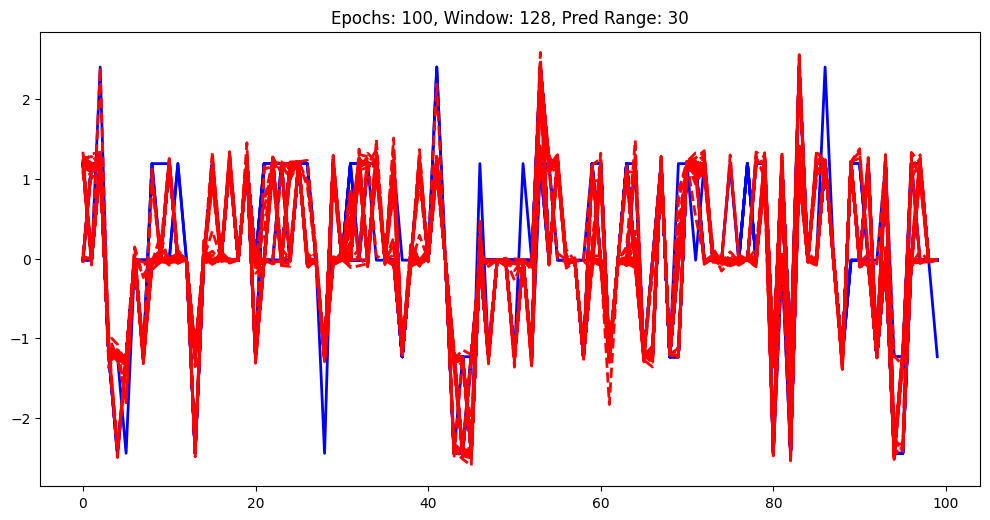

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=100, window_size=128, prediction_range=30)

###Bi-gru

#### 64 units   300 epochs   w=128   s=10   p=30

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


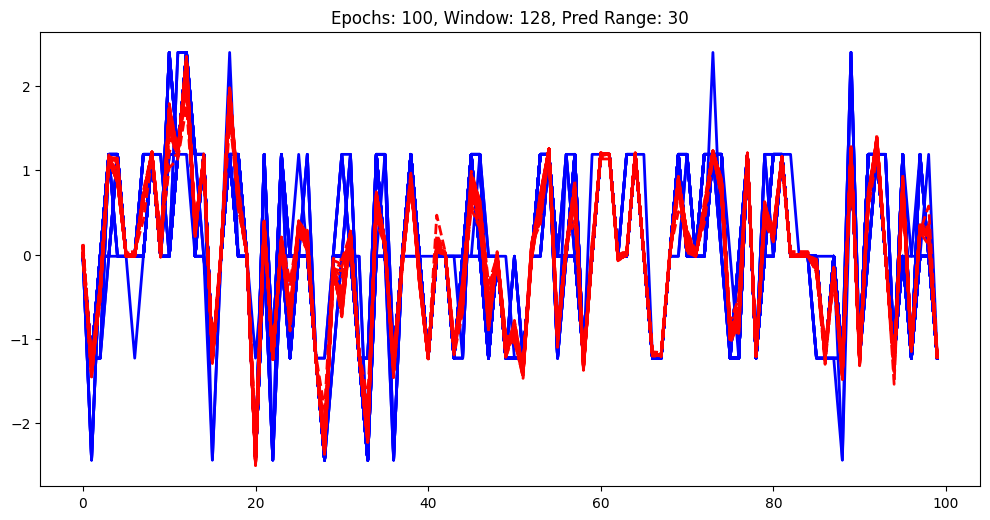

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=100, window_size=128, prediction_range=30)

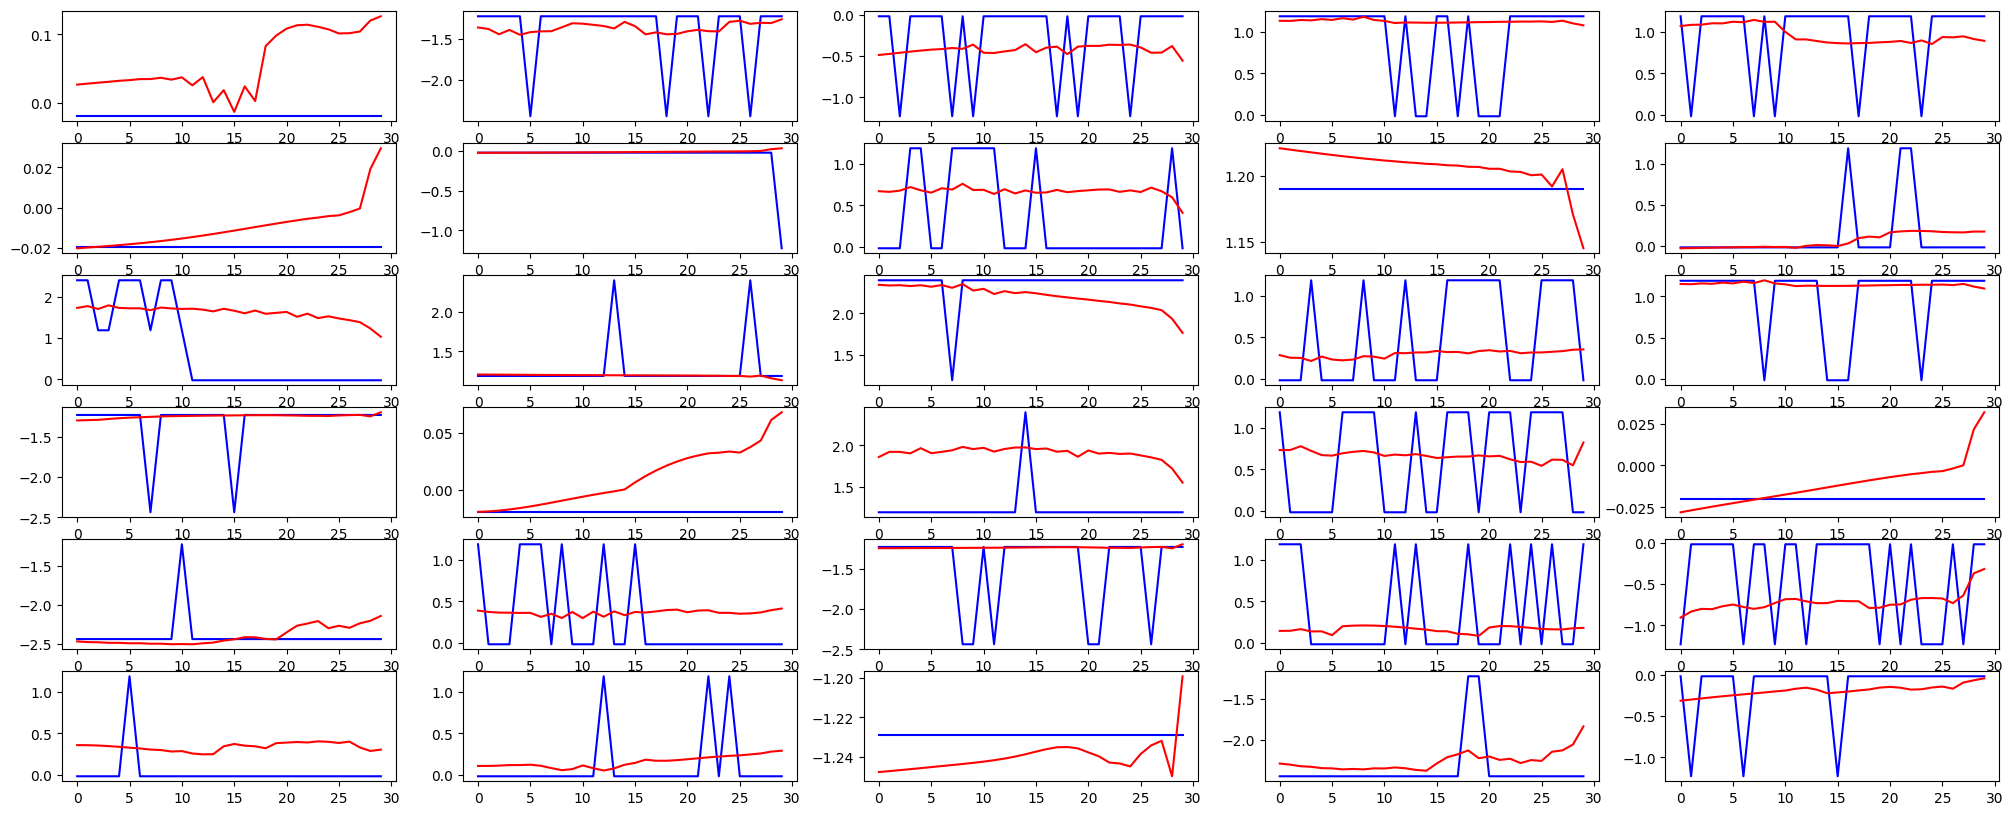

In [ ]:
plot_predictions(Y_test, predictions)

#### 64,128 units   300 epochs   w=128   s=10   p=30

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


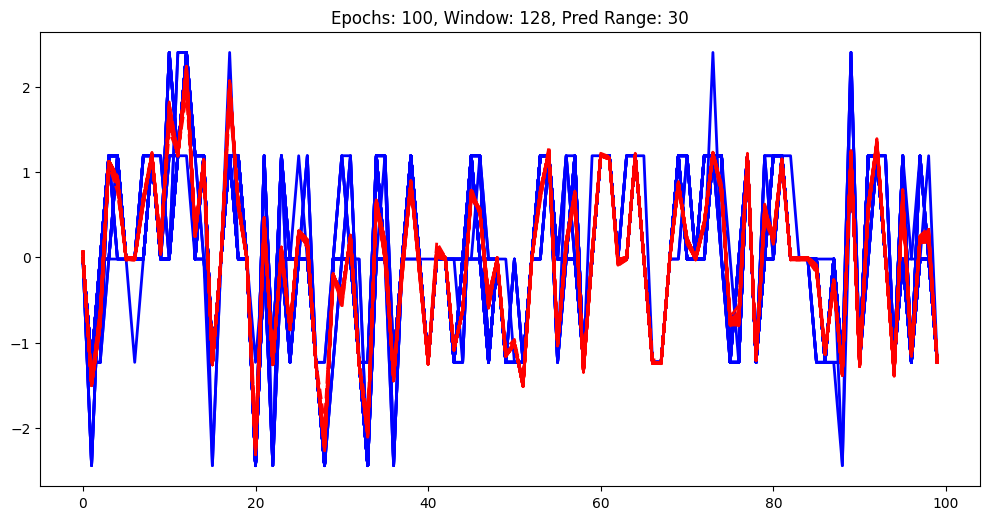

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=100, window_size=128, prediction_range=30)

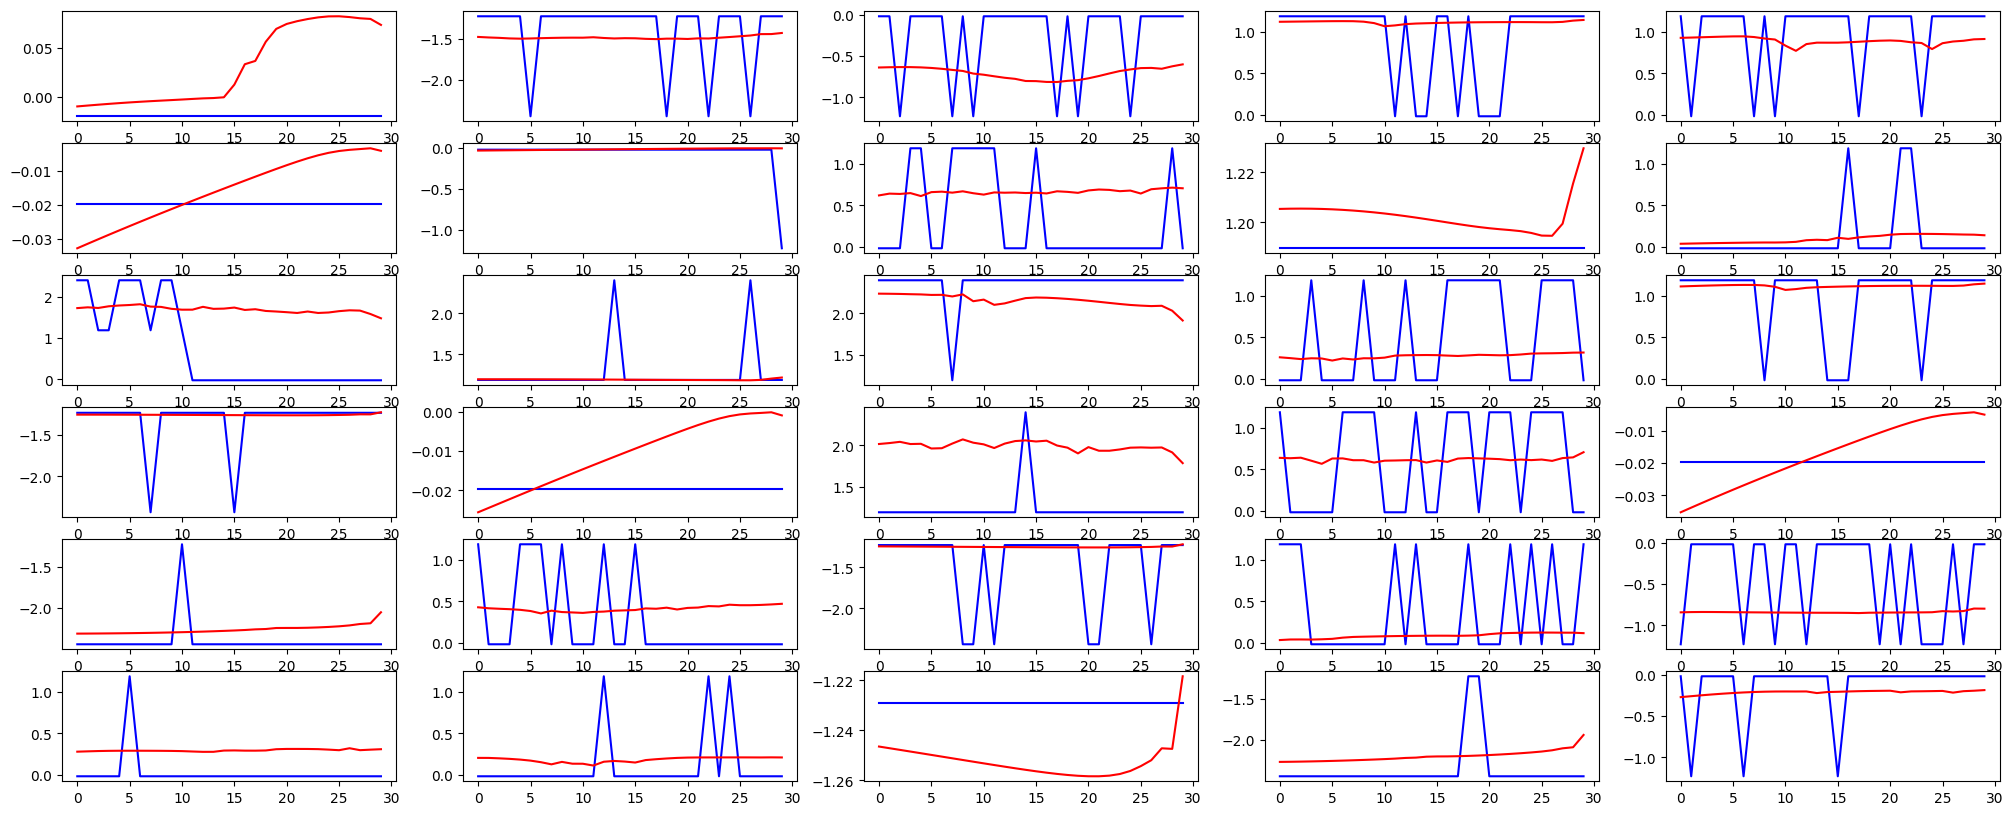

In [ ]:
plot_predictions(Y_test, predictions)

#### 128,256 units   300 epochs   w=128   s=10   p=30

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


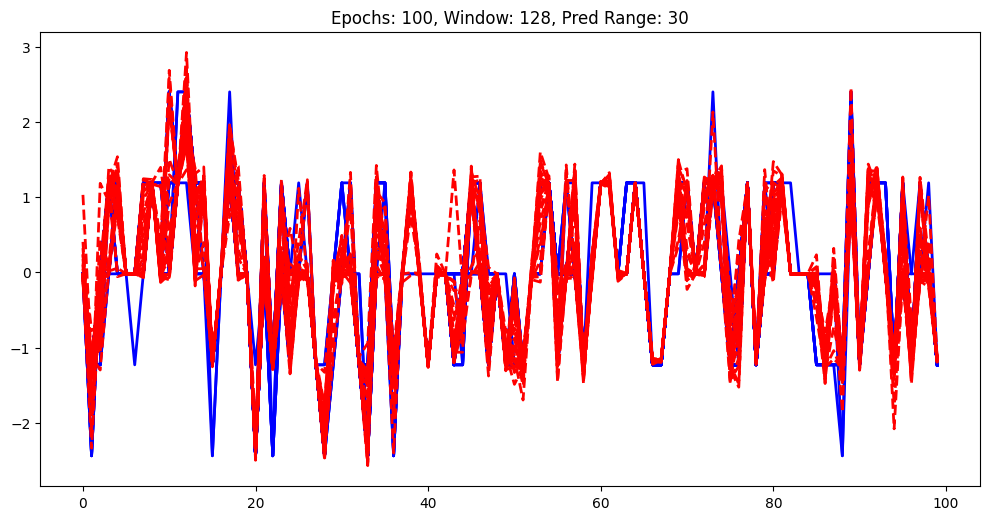

In [ ]:
predictions = model.predict(X_test)
plot_comparison(Y_test, predictions, epochs=100, window_size=128, prediction_range=30)

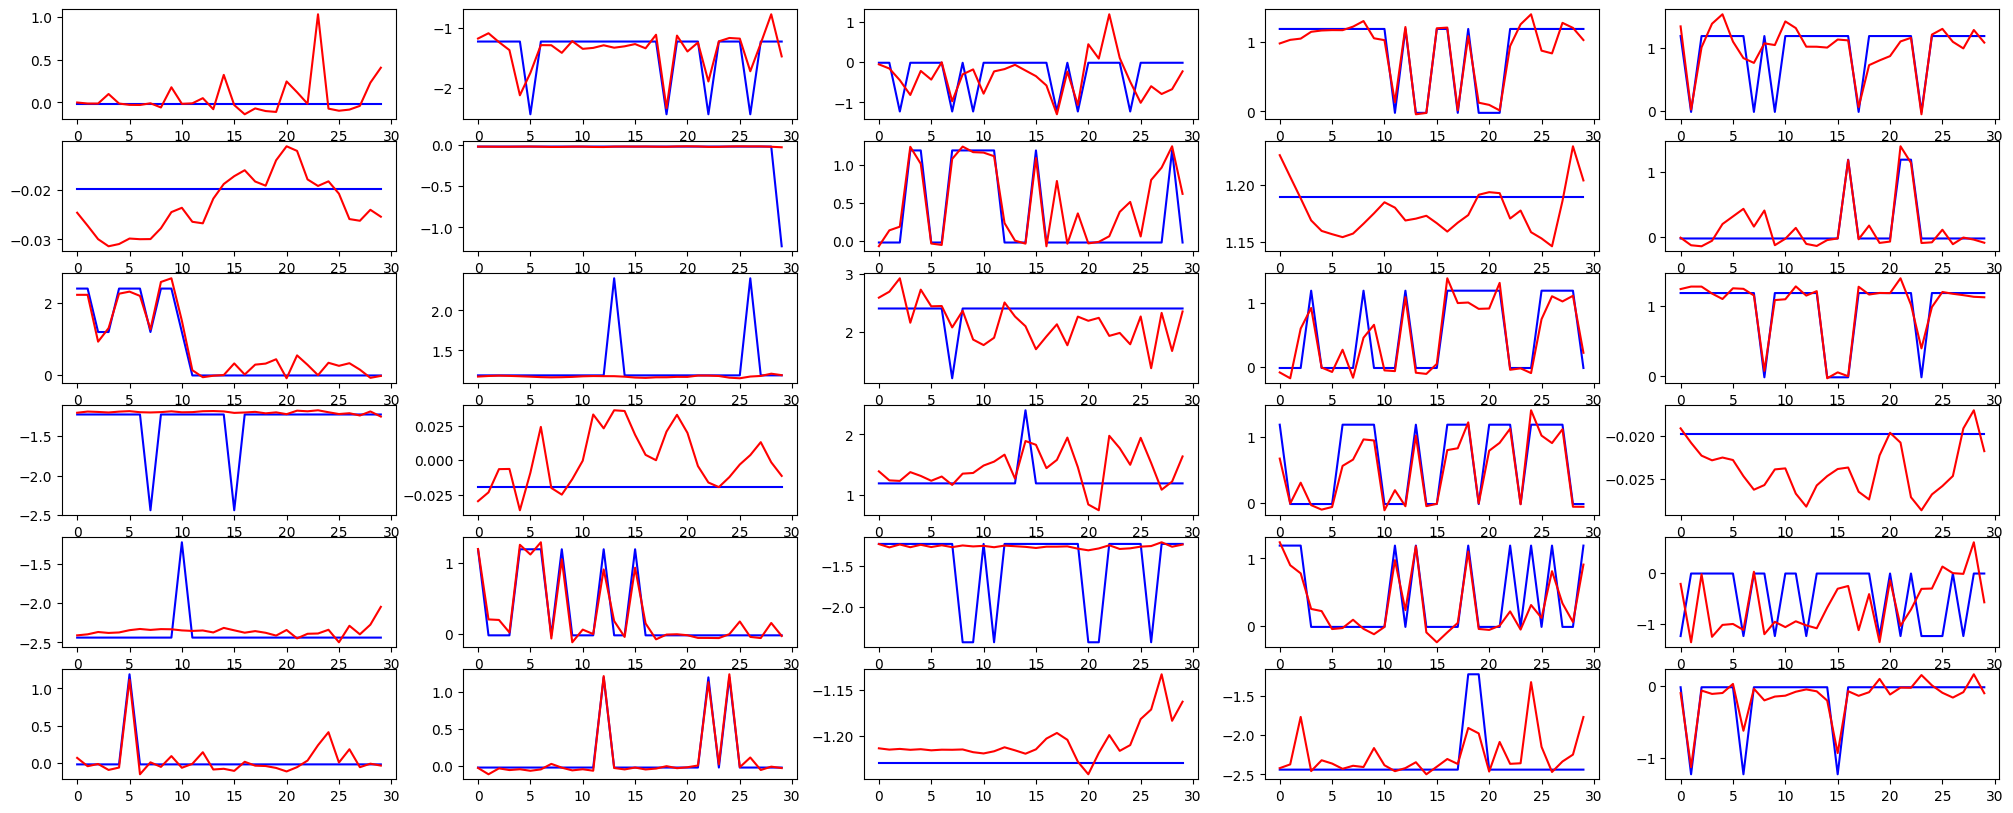

In [ ]:
plot_predictions(Y_test, predictions)